# word2vec: Tensorflow Tutorial

In which I walk through a [tutorial](https://www.tensorflow.org/tutorials/word2vec/) on building the [word2vec model](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) by Mikolov et al. I'll document justification for the code I write each step of the way. Much of the notes / images / code are / is copied or slightly altered from the tutorial.

## Imports

In [1]:
from __future__ import division, absolute_import, print_function

from six.moves import urllib, xrange

import tensorflow as tf
import numpy as np
import collections, math, os, random, zipfile

## Highlights

This Tensorflow tutorial is meant to highlight the interesting / substantive parts of building the word2vec model with Tensorflow.

- We motivate why we would walk to represent words as vectors.
- We look at the intuition behind the model and how it's trained, with mathematics as needed.
- We show a simple implementation of the model in TensorFlow.
- We look at ways to make the naive version of the model scale better.

One can dive into the [original, basic code](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py), or the [more complex version](https://github.com/tensorflow/models/blob/master/tutorials/embedding/word2vec.py), but walking through the tutorial will help us motivate the implementation of the model in those scripts.

Let's look at why we would want to learn word embeddings in the first place.

## Motivation: Why Learn Word Embeddings?

Image and audio processing machine learning systems work with rich and high-dimensional datasets encoded as vectors (of the individual raw pixels for image data, or as power spectral density coefficients for audio data). For tasks like object or speech recognition, we know that all the information required to successfully perform the task is encoded in the data (since us humans can perform the same tasks using the raw data). On the other hand, natural language processing (NLP) systems usually treat words as discrete, atomic symbols (e.g., "cat" and "dog" may be represented by `Id438` and `Id327`, respectively).

These encodings are arbitrary and provide no useful information to the machine learning system regarding the relationships that might exist between the individual symbols. This implies that machine learning systems cannot leverage what it knows about "cats" when processing data having to do with "dogs" (such that, they are both animals, four-legged, cute, ...). Representing words as these discrete objects also leads to data sparsity (the "[one-hot](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)" vector representation), and usually means that we may need more data in order to successfully train statistical models. Using word vector representations can overcome some of these problems.

![audio / image / text representations](https://www.tensorflow.org/images/audio-image-text.png)

[Vector space models](https://en.wikipedia.org/wiki/Vector_space_model) (VSMs) represent / embed words in a continuous vector space in which semantically similar words are mapped to nearby points; i.e., they are embedded nearby to each other. VSMs have a long, rich history in NLP, but all methods depend on some way on the [Distribution hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_Hypothesis), which states that words which appear in the same contexts share semantic meaning. The approaches which leverage this principle can be divided into two categories: _count-based methods_ (e.g., [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis)), and _predictive methods_ (e.g., [neural probabilistic language models](http://www.scholarpedia.org/article/Neural_net_language_models)).

In a nutshell, count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then maps these count statistics down to a small, dense vector for each word. Predictive models try to predict a word from its neighbors in terms of small, dense _embedding vectors_ (considered parameters of the model).

word2vec is a particularly computationally efficient predictive model for learning word embeddings from raw text. It comes in two flavors: the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model (Section 3.1, 3.2 in [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf)). These models are similar algorithmically, but CBOW predicts targets words from source context words (e.g., 'mat' from 'the cat sits on the'), whereas the Skip-Gram model does the inverse and predicts source context words from the target words. The inversion might seem like an arbitrary choice, but statistically, it has the effect that CBOW smooths over much of the distributional information (by treating an entire context as a single observation). This typically turns out to be useful for smaller datasets. However, Skip-Gram treats each context-target pair as a new observation, and this tends to perform better when we have larger datasets. We will focus on the Skip-Gram model for this tutorial.

## Scaling up with Noise-Contrastive Training

Neural probabilistic language models (NPLMs) are traditionally trained using the [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (ML) principle to maximize the probability of the next word $w_t$ ($t$ for "target") given the previous words $h$ (for "history") in terms of a [softmax function](https://en.wikipedia.org/wiki/Softmax_function):

<center>$P(w_t \text{ } | \text{ } h) = \text{softmax}(\text{score}(w_t, h))$</center>

<center>$ = \frac{\text{exp}(w_t, h)}{\sum_{\text{word w' in vocab}}\text{exp}(\text{score}(w_t, h))}$</center>

where $\text{score}(w_t, h)$ computes the probability of the word $w_t$ with the context $h$ (a dot product is typically used). We can train this model by maximizing its [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function) on the training datset:

<center>$J_{ML} = \text{log}(P(w_t \text{ } | \text{ } h))$</center>

<center>$ = \text{score}(w_t \text{ } | \text{ } h) - \text{log}(\sum_{\text{word w' in vocab}}\text{exp}(\text{score}(w_t, h)))$</center>

This gives a properly normalized probabilistic language model. However, this method is very expensive computationally, since we have to compute and normalize each probability using the score for all other $\text{Vocab } V$ words $w'$ in the current context $h$ at _every training step_.

![Softmax NPLM](https://www.tensorflow.org/images/softmax-nplm.png)

On the other hand, for feature learning in word2vec, we don't need a full probabilistic model. The CBOW and Skip-Gram models are instead trained using a binary classification objection ([logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)) to discriminate the real target words $w_t$ from $k$ imaginary / noise words $\tilde{w}$, in the same context. This is illustrated below for a CBOW model; for Skip-Gram, this illustratation is simply inverted:

![NCE-NPLM](https://www.tensorflow.org/images/nce-nplm.png)

Mathematically speaking, the objective (for each example) to be maximized is:

<center>$J_{NEG} = \text{log }Q_\theta(D = 1 \text{ } | \text{ } w_t, h) + k * \mathbb{E}_{\tilde{w} \text{ ~ } P_{\text{noise}}}[\text{log }Q_\theta(D = 0 \text{ } | \text{ } \tilde{w}, h)]$,</center>

where $Q_\theta(D = 1 \text{ } | \text{ } w_t, h)$ is the binary logistic regression probability under the model of seeing the word $w_t$ in the dataset $D$, calculated in terms of the learned embedding vectors $\theta$. In practice, we approximate the expectation by drawing $k$ contrastive words from the noise distribution; i.e., we compute a [Monte Carlo average](https://en.wikipedia.org/wiki/Monte_Carlo_integration).

The objective is maximized when the model assigns high probabilities to the real words and low probabilities to the noise words. This is called [negative sampling](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), and there is good mathematical motivation for using this loss function: the updates proposed by it approximate the updates of the softmax function in the limit. It is computationally appealing since computing the loss function now only scales with the number of _noise words_ we select, $k$, and not _all words_ in the vocabulary $V$. This makes the model much faster to train. We will actually make use of a very similar [noise-contrastive estimation](http://papers.nips.cc/paper/5165-learning-word-embeddings-efficiently-with-noise-contrastive-estimation.pdf) loss, for which Tensorflow has the helper function `tf.nn.nce_loss()`.

## The Skip-Gram Model

Let's consider the dataset `the quick brown fox jumped over the lazy dog`. We will first form a dataset of words and the contexts in which they appear. We can define "context" in any way that makes sense, and in fact people have looked at syntactic contexts, words-to-the-left of the target, words-to-the-right of the target, and more. We stick to the standard definition and define "context" as the window of words to the left and to the right of a target word. Using a window size of one, we now have the dataset: `([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...` of `(context, target)` pairs.

Recall that the Skip-Gram model inverts contexts and targets, and tries to predict each context word from its target word. So, the task becomes: predict "the" and "brown" from "quick", "quick" and "fox" from "brown", and so on. Our dataset then becomes: `(quick, the), (quick, brown), (brown, quick), (brown, fox), ...` of `(input, output)` pairs. The objective function is defined over the whole dataset, but we typically optimize it with [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) using one example (or a mini-batch of examples) at a time. Let's look at a single step of this process.

We can imagine that, at time $t$, we observe the first training case above, where the goal is to predict `the` from `quick`. We select `num_noise`, the number of noisy / contrastive examples, by drawing samples from some noise distribution (typically the unigram distribution, $P(w)$). For simplicity, let's say `num_noise = 1`, and we select `sheep` as our contrastive example. Next, we compute the loss for this pair of observed and noisy examples, i.e., the objective at time step $t$ is thus:

<center>$J^{(t)}_\text{NEG} = \log Q_\theta(D = 1 \text{ } | \text{ the, quick}) + \log(Q_\theta(D = 0 \text{ } | \text{ sheep, quick}))$.</center>

The idea is to update the embedding parameters $\theta$ so that the objective function moves towards its goal of maximize. We do this by deriving the gradient of the loss with respect to the embedding parameters $\theta$, i.e., $\frac{\partial}{\partial\theta}J_{NEG}$, easily done within TensorFlow. We perform an update to the embedding parameters by taking a small step in the direction of the gradient. When this process is repeated over the entire training dataset, it has the effect of "moving" the embedding vectors around for each word until the model is good at discriminating real words from noise words.

We can visualize the learned vector representation by projecting them down to tw0 or three dimensions using, for example, the [t-SNE dimensionality reduction technique](http://lvdmaaten.github.io/tsne/). Upon inspection, these visualizations show us that the vectors capture some general and quite useful semantic information about words and their relationships to one another. It is interesting to discover that certain directions in the induced vector space specialize towards certain semantic relationships; e.g., _male-female_, _verb tense_, and even _country-capital_ relationships between words, as illustrated below:

![Semantic Relationships](https://www.tensorflow.org/images/linear-relationships.png)

This also explains why vectors are useful as features for many standard NLP prediction tasks, such as part-of-speech tagging or name entity recognition.

## Getting the Data

We'll need to download the text data we want to work with, and then read the raw text data into a list of strings.

In [2]:
# download the data
url = 'http://mattmahoney.net/dc/'

def download(filename, expected_bytes):
    """
    Download a file if not present, and make sure it's the right size.
    """
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

# download the file
file_ = download('text8.zip', 31344016)

def read_data(filename):
    """
    Parse the file enclosed in the 'filename' zip file into a list of words.
    """
    # unzip the file
    with zipfile.ZipFile(filename) as f:
        # read the data into the 'data' variable
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    # return the data
    return data

words = read_data(file_)
print('data size:', len(words))

Found and verified text8.zip
data size: 17005207


## Building the Word Dictionary and Replacing Rare Words

Now that we've read in the raw text and converting it into a list of strings, we'll need to convert this list into a dictionary of `(input, output)` pairs as described above for the Skip-Gram model. We'll also replace rare words in the dictionary with the token `UNK`, as is standard in this kind of NLP task.

In [3]:
# build the dictionary and replace rare words with the "UNK" token.
vocabulary_size = 50000

def build_dataset(words):
    # create counts list, set counts for "UNK" token to -1 (undefined)
    count = [['UNK', -1]]
    # add counts of the 49,999 most common tokens in 'words'
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # create the dictionary data structure
    dictionary = {}
    # give a unique integer ID to each token in the dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # create a list data structure for the data
    data = []
    # keep track of the number of "UNK" token occurrences
    unk_count = 0
    # for each word in our list of words
    for word in words:
        # if its in the dictionary, get its index
        if word in dictionary:
            index = dictionary[word]
        # otherwise, set the index equal to zero (index of "UNK") and increment the "UNK" count
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        # append its index to the 'data' list structure
        data.append(index)
    # set the count of "UNK" in the 'count' data structure
    count[0][1] = unk_count
    # invert the dictionary; it becomes (index, word) key-value pairs
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    # return the data (indices), counts, dictionary, and inverted dictionary
    return data, count, dictionary, reverse_dictionary

# build the datset
data, count, dictionary, reverse_dictionary = build_dataset(words)
# free up some memory
del words
# print out stats
print('most common words (+UNK):', count[:10])
print('sample data:', data[:10], [reverse_dictionary[i] for i in data[:10]])

most common words (+UNK): [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
sample data: [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Generating Minibatches for Model Training

We define a function which allows us to generate mini-batches for training the skip-gram model.

In [5]:
data_index = 0

# generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # make sure our parameters are self-consistent
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    # create empty batch ndarray using 'batch_size'
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    # create empty labels ndarray using 'batch_size'
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # [ skip_window target skip_window ]
    span = 2 * skip_window + 1
    # create a buffer object for prepping batch data
    buffer = collections.deque(maxlen=span)
    # for each element in our calculated span, append the datum at 'data_index' and increment 'data_index' moduli the amount of data
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # loop for 'batch_size' // 'num_skips'
    for i in range(batch_size // num_skips):
         # target label at the center of the buffer
        target = skip_window
        targets_to_avoid = [skip_window]
        # loop for 'num_skips'
        for j in range(num_skips):
            # loop through all 'targets_to_avoid'
            while target in targets_to_avoid:
                # pick a random index as target
                target = random.randint(0, span - 1)
            # put it in 'targets_to_avoid'
            targets_to_avoid.append(target)
            # set the skip window in the minibatch data
            batch[i * num_skips + j] = buffer[skip_window]
            # set the target in the minibatch labels
            labels[i * num_skips + j, 0] = buffer[target]
        # add the data at the current 'data_index' to the buffer
        buffer.append(data[data_index])
        # increment 'data_index'
        data_index = (data_index + 1) % len(data)
    # return the minibatch data and corresponding labels
    return batch, labels

# get a minibatch
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

# print out part of the minibatch to the console
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3084 originated -> 12 as
3084 originated -> 5239 anarchism
12 as -> 6 a
12 as -> 3084 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


## Building the Computation Graph

We set up some hyperparameters and set up the computation graph.

In [7]:
# hyperparameters
batch_size = 128
embedding_size = 128 # dimension of the embedding vector
skip_window = 1 # how many words to consider to left and right
num_skips = 2 # how many times to reuse an input to generate a label

# we choose random validation dataset to sample nearest neighbors
# here, we limit the validation samples to the words that have a low
# numeric ID, which are also the most frequently occurring words
valid_size = 16 # size of random set of words to evaluate similarity on
valid_window = 100 # only pick development samples from the first 'valid_window' words
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64 # number of negative examples to sample

# create computation graph
graph = tf.Graph()

with graph.as_default():
    # input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # operations and variables
    # look up embeddings for inputs
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                     labels=train_labels, inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    # construct the SGD optimizer using a learning rate of 1.0
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # compute the cosine similarity between minibatch examples and all embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # add variable initializer
    init = tf.initialize_all_variables()

## Training the Model

In [10]:
# steps to train the model
num_steps = 100001

with tf.Session(graph=graph) as session:
    # we must initialize all variables before using them
    init.run()
    print('initialized.')
    
    # loop through all training steps and keep track of loss
    average_loss = 0
    for step in xrange(num_steps):
        # generate a minibatch of training data
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # we perform a single update step by evaluating the optimizer operation (including it
        # in the list of returned values of session.run())
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print average loss every 2,000 steps
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # the average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        
        # computing cosine similarity (expensive!)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                # get a single validation sample
                valid_word = reverse_dictionary[valid_examples[i]]
                # number of nearest neighbors
                top_k = 8
                # computing nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
        
    final_embeddings = normalized_embeddings.eval()

initialized.
Average loss at step  0 :  288.309387207
nearest to four: inappropriately, leninist, altruistic, unsupported, ect, taito, theist, adria,
nearest to one: nabataean, rt, rosa, jeb, jscript, thucydides, electronegativity, popularizer,
nearest to more: polluted, photographed, gec, hideous, reason, gk, cook, drying,
nearest to to: enthroned, homicides, burger, hobbit, marquise, monophyletic, nomination, stake,
nearest to time: lica, links, quicksort, meshech, warring, deadlines, fouling, lola,
nearest to can: revenge, kublai, alzheimer, teamed, inquiries, seen, madness, stencil,
nearest to UNK: holies, compensation, smoker, thatcher, modulo, sampling, aka, sway,
nearest to see: kellogg, mnemonic, stairway, stair, emilio, marcuse, rowers, progressions,
nearest to or: staffed, differs, void, dwellings, aniston, nightmare, vertical, alexandrine,
nearest to up: patched, ottoman, trivia, worshippers, virus, qin, wears, chakras,
nearest to were: reading, pornography, peripatetic, aru

## Visualizing the Embeddings

Let's plot the embedding vectors learned from the word2vec training using [t-SNE](http://lvdmaaten.github.io/tsne/).

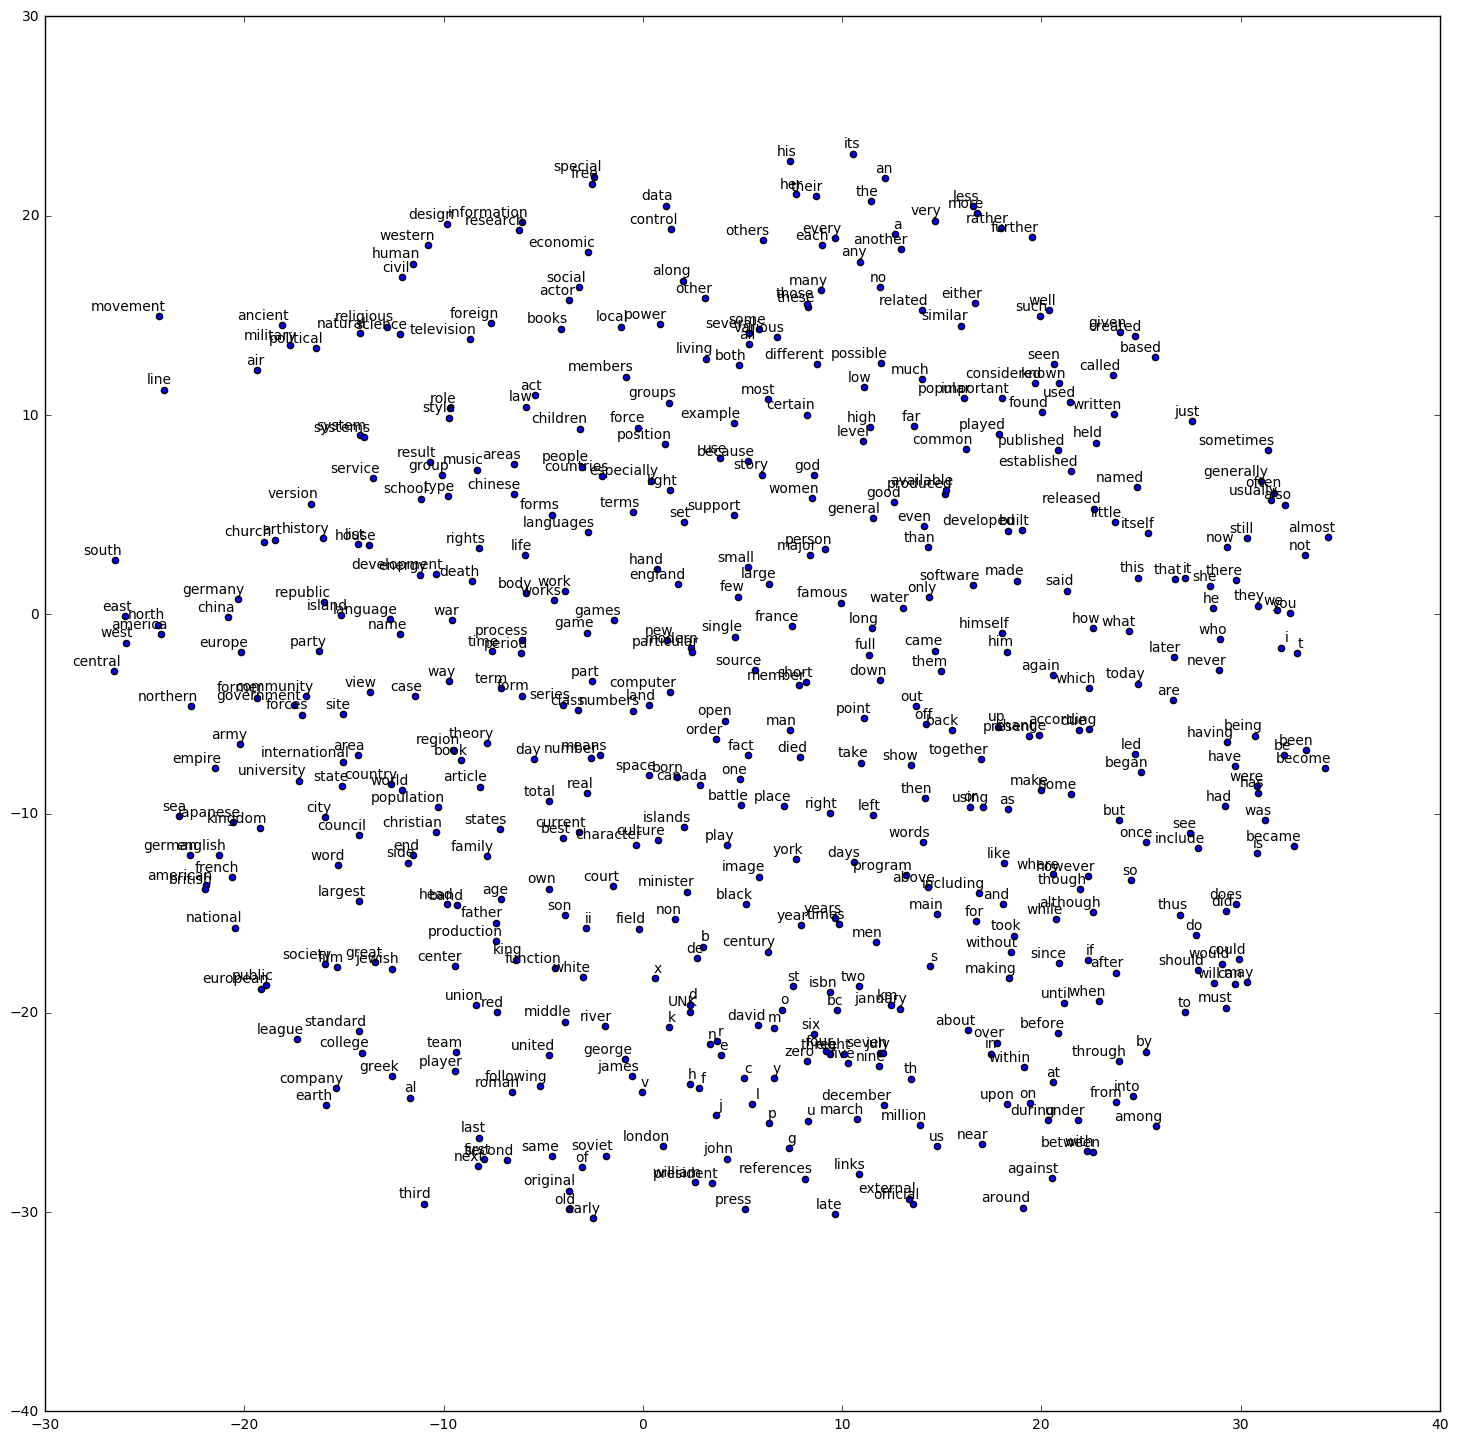

In [12]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    # set plot size in inches
    plt.figure(figsize=(18, 18))
    # loop through all labels
    for i, label in enumerate(labels):
        # get the embedding vectors
        x, y = low_dim_embs[i, :]
        # plot them in a scatterplot
        plt.scatter(x, y)
        # annotations
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    # save the figure out
    plt.savefig(filename)

try:
    # import t-SNE and matplotlib.pyplot
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    %matplotlib inline

    # create the t-SNE object with 2 components, PCA initialization, and 5000 iterations
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    # plot only so many words in the embedding
    plot_only = 500
    # fit the TSNE dimensionality reduction technique to the word vector embedding
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    # get the words associated with the points
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    # call the plotting function
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

As expected, words that are similar end up clustering nearby one another (his, her, its, theirs; could, should would, must, will, may; have, had, having, being, been, be, become, became, is; ...).

## Analyzing Embeddings: Analogical Reasoning

Embeddings are useful for many prediction tasks in NLP. Short of training a full part-of-speech model or named-entity model, a simple way to evaluate embeddings is to directly use them to predict syntax and semantic relationships such as `king is to queen as father is to ?`. This is called _analogical reasoning_, and the task was introduced by [Mikolov et al.](http://msr-waypoint.com/en-us/um/people/gzweig/Pubs/NAACL2013Regularities.pdf). The dataset for this task is available [here](http://download.tensorflow.org/data/questions-words.txt).

To see how to do the evaluation, consult the `build_eval_graph()` and `eval()` functions in [tensorflow/models/embedding/word2vec.py](https://www.tensorflow.org/code/tensorflow/models/embedding/word2vec.py). 

The choice of hyperparameters can strongly affect the accuracy on the task. To achieve state-of-the-art performance on this task requires training on a very large dataset, carefully tuning the hyperparameters, and making use of tricks like subsampling the data (out of scope of this tutorial).

## Optimizing the Implementation

The above simple implementation showcases the flexibility of TensorFlow. For example, changing the training objective is as simple as switching out the call to `tf.nn.nce_loss()` for an off-the-shelf alternative such as `tf.nn.sampled_softmax_loss()`. If you have new ideas for a loss function, you can manually write an expression for the new objective in TensorFlow and let the optimizer compute the derivatives. This flexibility is very valuable in the exploratory phase of machine learning model development, in which we want to try out several different ideas and iterate on them quickly.

Once you have a model architecture which you're happy with, it may be worth optimizing the implementation to run more efficiently and cover more data in less time. For example, the simple code used above would suffer compromised speed since we use Python for read data and feeding it to our model - both of which require very little work on the TensorFlow back-end. If your model is seriously bottle-necking on input data, you may want to implement a custom data reading tool for your problem, as described [here](https://www.tensorflow.org/how_tos/new_data_formats/). In the case of the Skip-Gram model, this is already done in the [more advanced TensorFlow implementation of word2vec](https://www.tensorflow.org/code/tensorflow/models/embedding/word2vec.py).

If your model is no longer I/O bound but you still want better performance, you can write your own [TensorFlow Ops](https://www.tensorflow.org/how_tos/adding_an_op/). There is an example of this for the Skip-Gram model in TensorFlow [here](https://www.tensorflow.org/code/tensorflow/models/embedding/word2vec_optimized.py).

## Conclusion

We covered the word2vec model, a computationally efficient model for learning word embeddings. We motivated the usefulness of word embeddings, discussed efficient training techniques, and gave a simple implementation of it in TensorFlow. The hope is that the tutorial showcased how TensorFlow is flexible enough for doing early experimentation easily, yet powerful enough to give you the control you need for bespoke optimized implementations.